In [1]:
import pandas as pd
import numpy as np
import os
import re
import time
import datetime
import gc
import string
import re
import seaborn as sns 
import matplotlib.pyplot as plt 
import math

from decimal import Decimal, getcontext

# --------------------------------------------

Q = 1.0
m = 1
N = 2*50
kB = 1
Temp_Target = 1
e0 = 1.0


Lim_Inf = 175000
Lim_Sup = 1000000

# --------------------------------------------

output_dir = r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\3. Test"

Partic_DF=pd.read_csv(r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\3. Test\Analitica Nosee Hoover IG\Particle_Data.csv")
System_DF=pd.read_csv(r"E:\Cristian\1. Molecular Dinamics\2. Python Projects\3. Jupiter Code\3. Test\Analitica Nosee Hoover IG\System_Data.csv")


In [2]:
def obtener_columnas_object(dataframe):
    columnas_object = []
    tipos_datos = dataframe.dtypes
    for columna, tipo in tipos_datos.items():
        if tipo == 'object':
            columnas_object.append(columna)
    return columnas_object

# -------- Conversión de data types y alistamiento de dataframes originales --------

columns_to_convert = obtener_columnas_object(System_DF)
# print(columns_to_convert)
System_DF[columns_to_convert] = System_DF[columns_to_convert].replace(',', '.', regex=True)
System_DF[columns_to_convert] = System_DF[columns_to_convert].astype(float)
# print(System_DF.dtypes)

columns_to_convert = obtener_columnas_object(Partic_DF)
# print(columns_to_convert)
Partic_DF[columns_to_convert] = Partic_DF[columns_to_convert].replace(',', '.', regex=True)
Partic_DF[columns_to_convert] = Partic_DF[columns_to_convert].astype(float)
# print(Partic_DF.dtypes)


In [3]:

Partic_DF = Partic_DF[(Partic_DF['Step'] >= Lim_Inf) & (Partic_DF['Step'] <= Lim_Sup)]
System_DF = System_DF[(System_DF['Step'] >= Lim_Inf) & (System_DF['Step'] <= Lim_Sup)]


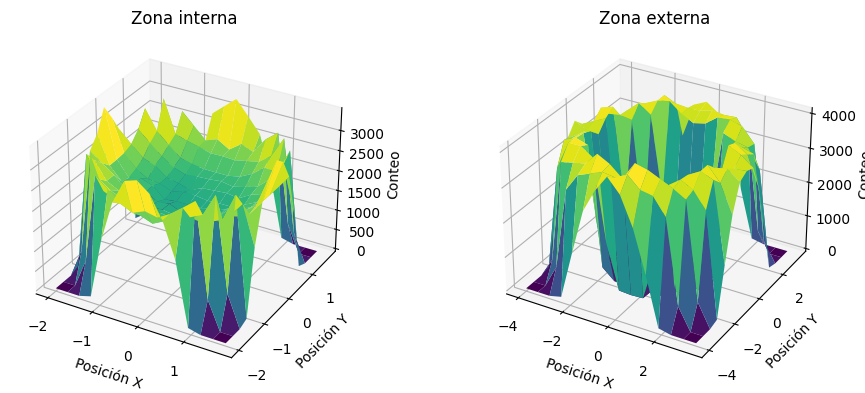

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Suponiendo que tienes un DataFrame llamado Partic_DF con columnas "X_Pos" y "Y_Pos"

# Definir los radios de las dos zonas de interés
r_2 = 4.0         #Disc 2 RatioTemp
r_1 = 2.0         #Disc 1 Ratio
r_G = 2.5         #Gap Ratio

# Obtener las posiciones X, Y del DataFrame
x = Partic_DF["X_Pos"]
y = Partic_DF["Y_Pos"]

# Calcular las distancias desde el origen
distancias = np.sqrt(x**2 + y**2)

# Crear máscaras para seleccionar los puntos correspondientes a cada zona
mask_interna = distancias <= r_1
mask_externa = np.logical_and(distancias > r_G, distancias <= r_2)

# Obtener las coordenadas correspondientes a cada zona
x_interna = x[mask_interna]
y_interna = y[mask_interna]
x_externa = x[mask_externa]
y_externa = y[mask_externa]

# Crear una malla para la zona interna
bins_interna = 15  # Ajusta el número de bins según tus necesidades
counts_interna, x_edges_interna, y_edges_interna = np.histogram2d(x_interna, y_interna, bins=bins_interna)
X_interna, Y_interna = np.meshgrid(x_edges_interna[:-1], y_edges_interna[:-1])
Z_interna = counts_interna.T

# Crear una malla para la zona externa
bins_externa = 15  # Ajusta el número de bins según tus necesidades
counts_externa, x_edges_externa, y_edges_externa = np.histogram2d(x_externa, y_externa, bins=bins_externa)
X_externa, Y_externa = np.meshgrid(x_edges_externa[:-1], y_edges_externa[:-1])
Z_externa = counts_externa.T

# Crear la figura y los gráficos 3D
fig = plt.figure(figsize=(10, 4))

# Graficar la zona interna
ax_interna = fig.add_subplot(121, projection='3d')
ax_interna.plot_surface(X_interna, Y_interna, Z_interna, cmap='viridis')
ax_interna.set_title('Zona interna')
ax_interna.set_xlabel('Posición X')
ax_interna.set_ylabel('Posición Y')
ax_interna.set_zlabel('Conteo')

# Graficar la zona externa
ax_externa = fig.add_subplot(122, projection='3d')
ax_externa.plot_surface(X_externa, Y_externa, Z_externa, cmap='viridis')
ax_externa.set_title('Zona externa')
ax_externa.set_xlabel('Posición X')
ax_externa.set_ylabel('Posición Y')
ax_externa.set_zlabel('Conteo')

# Ajustar la disposición de los gráficos
fig.tight_layout()
fig.savefig(os.path.join(output_dir, "3D_Charge_Dist.png"))

# Mostrar los gráficos
plt.show()

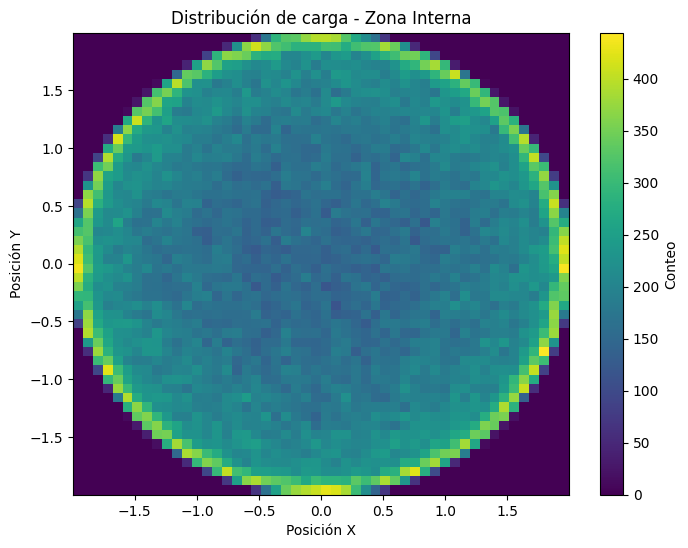

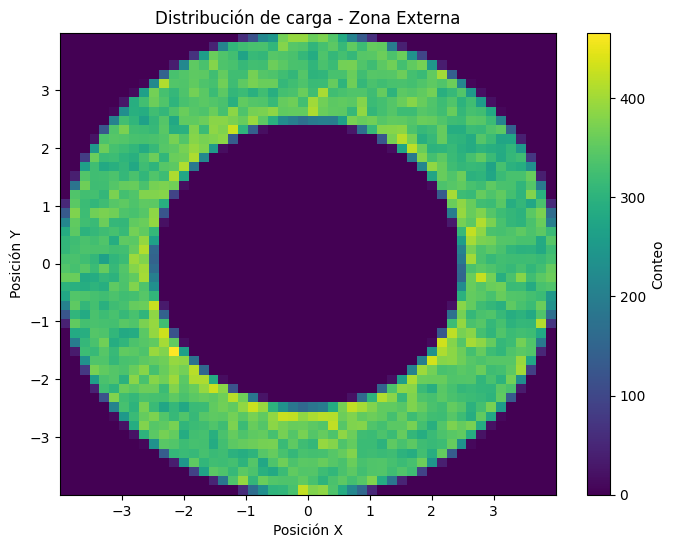

In [24]:
def graficar_zona(Partic_DF, r_1, r_2, bins, zona, name):
    # Obtener las posiciones X, Y del DataFrame
    x = Partic_DF["X_Pos"]
    y = Partic_DF["Y_Pos"]

    # Calcular las distancias desde el origen
    distancias = np.sqrt(x**2 + y**2)

    # Crear máscaras para seleccionar los puntos correspondientes a cada zona
    mask_interna = distancias <= r_1
    mask_externa = np.logical_and(distancias > r_G, distancias <= r_2)

    # Obtener las coordenadas correspondientes a la zona seleccionada
    if zona == "interna":
        x_zona = x[mask_interna]
        y_zona = y[mask_interna]
    elif zona == "externa":
        x_zona = x[mask_externa]
        y_zona = y[mask_externa]
    else:
        raise ValueError("La zona debe ser 'interna' o 'externa'.")

    # Crear el gráfico de la zona seleccionada
    plt.figure(figsize=(8, 6))
    plt.hist2d(x_zona, y_zona, bins=bins, cmap='viridis')
    plt.colorbar(label='Conteo')
    plt.title(f"Distribución de carga - Zona {zona.capitalize()}")
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')

    plt.savefig(os.path.join(output_dir, name))
    
    # Mostrar el gráfico
    plt.show()
    
graficar_zona(Partic_DF, r_1, r_2, 50, "interna", "2D_Int_Charge_Dist.png")
graficar_zona(Partic_DF, r_1, r_2, 50, "externa", "2D_Ext_Charge_Dist.png")


In [6]:
# Calcula la suma de 'Ke_Energy' para cada valor único en 'Step'
grouped_sum = Partic_DF.groupby('Step')['Ke_Energy'].sum()

# Asigna la suma correspondiente a cada fila en 'Calo_Cap'
Partic_DF['Ke_Total'] = Partic_DF['Step'].map(grouped_sum)

Partic_DF['Ke_Mean'] = Partic_DF['Vel_M']**2
Partic_DF['Ke_Mean'] = Partic_DF.groupby('Step')['Ke_Mean'].transform('mean')
Partic_DF['Ke_Mean'] = Partic_DF['Ke_Mean']*m*0.5



# Agrupa por 'Step' y asigna el cálculo correspondiente a cada fila en la columna 'Columna_Nueva'
# Partic_DF['Ke_Mean'] = Partic_DF.groupby('Step')['Vel_M'**2].transform('mean')

# # Partic_DF['Ke_Mean'] = 0.5*m*Partic_DF['Ke_Mean']

In [7]:
from numpy import linalg as LA

def magnitude(vector) : 
    return LA.norm(vector)

def q(n) : 
    if n < N/2: 
      return Q # n will start at zero
    else : 
      return -Q

def Potencial_Energy(df):
    N = len(df)  # Obtener el número de filas en el DataFrame
    rVector = df[['X_Pos', 'Y_Pos']].values  # Obtener los valores de las columnas 'x' y 'y' como una matriz numpy
    Conts = 1 / (4 * np.pi * e0)
    Sum_m = 0
    
    for m in range(0, N):
        Qm = q(m)
        Sum_n = 0
        
        for n in range(0, N):
            if m != n:
                Qn = q(n)
                Dist = magnitude(rVector[n] - rVector[m])
                Sum_n += Qn * Conts * (1 / Dist)
      
        Sum_m += Qm * Sum_n
    
    return Sum_m

grouped = Partic_DF.groupby('Step')

for step, group in grouped:
    # print (100 * step/len(Partic_DF))
    Pot_Energy = Potencial_Energy(group)
    Partic_DF.loc[group.index, 'Pot_Energy'] = Pot_Energy



21.20955035753242
21.22167010059387
21.233789843655316
21.245909586716763
21.258029329778207
21.270149072839654
21.2822688159011
21.29438855896255
21.306508302023996
21.318628045085443
21.33074778814689
21.342867531208338
21.354987274269785
21.367107017331232
21.37922676039268
21.391346503454127
21.403466246515574
21.41558598957702
21.42770573263847
21.439825475699916
21.451945218761363
21.46406496182281
21.476184704884258
21.488304447945705
21.500424191007152
21.5125439340686
21.524663677130047
21.53678342019149
21.548903163252938
21.561022906314385
21.573142649375832
21.58526239243728
21.597382135498727
21.609501878560174
21.62162162162162
21.63374136468307
21.645861107744516
21.657980850805963
21.67010059386741
21.682220336928857
21.694340079990305
21.706459823051752
21.7185795661132
21.730699309174646
21.742819052236094
21.75493879529754
21.767058538358988
21.779178281420435
21.791298024481883
21.80341776754333
21.815537510604774
21.82765725366622
21.839776996727668
21.851896739789

In [8]:
# Realizar la fusión (merge) de los DataFrames basándote en la columna 'Step'
Partic_DF = pd.merge(Partic_DF, System_DF[['Step', 'Temp_Tar']], on='Step', how='left')
Partic_DF = pd.merge(Partic_DF, System_DF[['Step', 'Temp_Act']], on='Step', how='left')

In [9]:
Partic_DF['Total_E'] = Partic_DF['Ke_Total'] + Partic_DF['Pot_Energy']
Partic_DF['Total_EE'] = Partic_DF['Total_E']**2

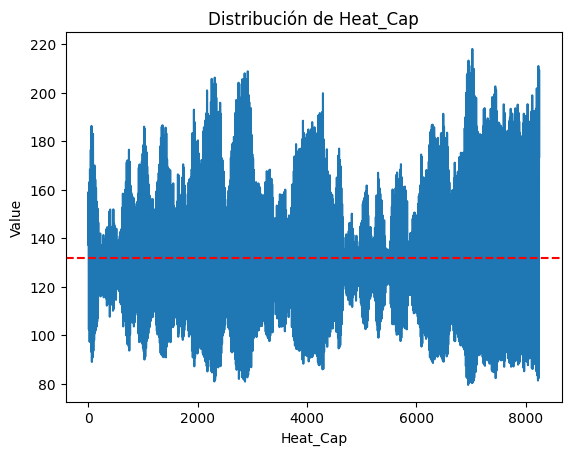

132.05188432313898


In [25]:
Partic_DF['Heat_Cap'] =  (1/(kB*(Partic_DF['Temp_Act']**2))) * (Partic_DF['Total_EE'].mean() - ((Partic_DF['Total_E'].mean())**2))

def Plot_Dist (df,colum,line_value,name):

    # Group the DataFrame by the 'Steps' column
    grouped_df = df.groupby('Step')

    # Extract the unique values of the 'Value' column
    unique_values = grouped_df[colum].unique()
    
    plt.close("all") #this is the line to be added
    num_steps = len(unique_values)
    plt.plot(range(num_steps), unique_values)
    plt.xlabel('Heat_Cap')
    plt.ylabel('Value')
    plt.title('Distribución de Heat_Cap')
    # plt.savefig(os.path.join(output_dir, "Vy_Mean_Distribution.png"))
    plt.axhline(y=line_value, color='red', linestyle='--')
    plt.savefig(os.path.join(output_dir, name))
    plt.show()
    
Plot_Dist(Partic_DF,'Heat_Cap',Partic_DF['Heat_Cap'].mean(),"Heat_Cap_Dist.png")
print(Partic_DF['Heat_Cap'].mean())
